In [1]:
import torch
from transformers import BertTokenizer
from datasets import load_dataset
import numpy as np
# Print the length of dataset train dialogue and summary in histogram
import matplotlib.pyplot as plt

from datasets import load_dataset


In [2]:
def reduce_dataset_sizes(dataset, train_split=100, val_split=20, test_split=30):
    for (
        split_name
    ) in dataset.keys():  # Iterate through all splits ('train', 'validation', 'test')

        if split_name == "train":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(train_split))

        if split_name == "validation":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(val_split))

        if split_name == "test":
            reduced_split = dataset[split_name].shuffle(seed=42).select(range(test_split))

        dataset[split_name] = reduced_split
    return dataset

In [4]:
emotions = [
    "admiration", "amusement", "anger", "annoyance", "approval", 
    "caring", "confusion", "curiosity", "desire", "disappointment", 
    "disapproval", "disgust", "embarrassment", "excitement", "fear", 
    "gratitude", "grief", "joy", "love", "nervousness", 
    "optimism", "pride", "realization", "relief", "remorse", 
    "sadness", "surprise", "neutral"
]

carer_emotions = ["anger", "fear", "joy", "love", "sadness", "surprise"]


In [5]:
goemotions = "google-research-datasets/go_emotions"
ds_goemotions = load_dataset(goemotions, "simplified")

carer = "dair-ai/emotion"
ds_carer = load_dataset(carer)

print(ds_goemotions)
print(ds_carer)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
reduced_ds = reduce_dataset_sizes(ds_goemotions)
print('Train size:', len(reduced_ds["train"]))
print('Validation size:', len(reduced_ds["validation"]))
print('Test size:', len(reduced_ds["test"]))

Train size: 100
Validation size: 20
Test size: 30


In [6]:
print(reduced_ds["train"]["labels"][:10])

[[9, 25], [5], [27], [5], [3], [17], [27], [0], [4], [27]]


In [8]:
def print_histogram(texts, labels, dataset_type, id2label=None, title=None):
  input_lengths = [len(text) for text in texts]
  
  print("Maximum length of 'title' column:", max(input_lengths))
  print("Minimum length of 'title' column:", min(input_lengths))
  print("Median length of 'title' column", np.median(input_lengths))
  print("Mean length of 'title' column", np.mean(input_lengths))
  print("STD of 'title' column", np.std(input_lengths))
  
  # Have more label in x axis
  plt.hist(input_lengths, bins=28)
  plt.xlabel("Text Length")
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Text Lengths ({dataset_type})")
  plt.show()
  
 # Check if labels is a list of lists or a single list
  if isinstance(labels[0], list):
      # If it's a list of lists, flatten it
      em_labels = [item for sublist in labels for item in sublist]
  else:
      # If it's a single list or integer, handle accordingly
      em_labels = labels

  # Now proceed with your plotting or further processing
  plt.hist([id2label[label] for label in em_labels], bins=20)
  plt.xlabel("Labels")

  plt.xticks(rotation=90)
  plt.ylabel("Frequency")
  plt.title(f"Distribution of Labels ({title} - {dataset_type})")
  plt.show()

Maximum length of 'title' column: 703
Minimum length of 'title' column: 2
Median length of 'title' column 65.0
Mean length of 'title' column 68.40087537433772
STD of 'title' column 36.721474806613095


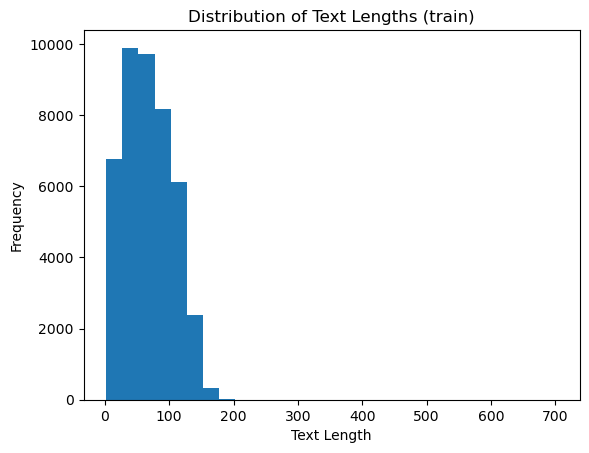

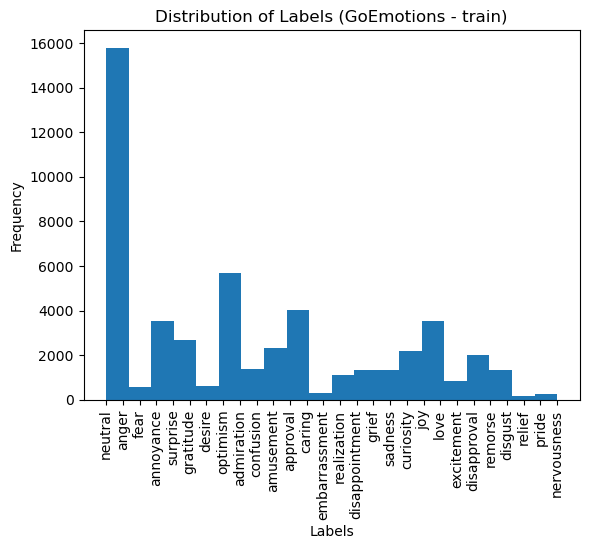

Maximum length of 'title' column: 300
Minimum length of 'title' column: 7
Median length of 'title' column 86.0
Mean length of 'title' column 96.8458125
STD of 'title' column 55.90320575525919


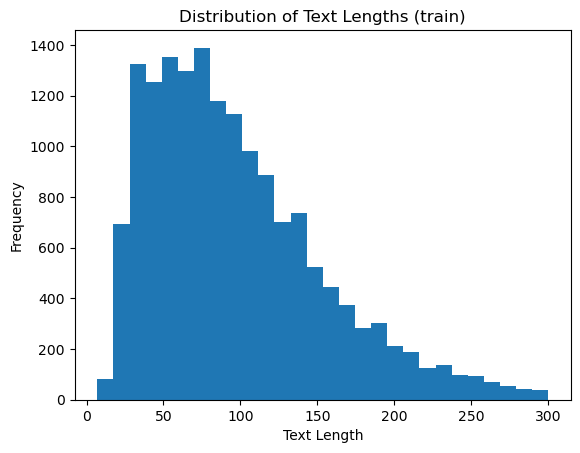

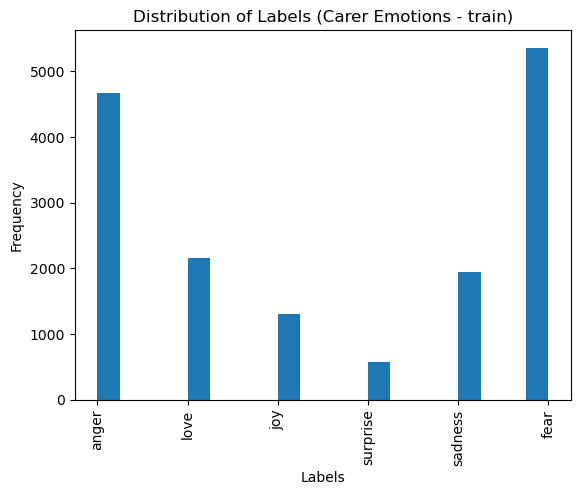

In [ ]:
# ds_neutral = ds_goemotions.filter(lambda x: 27 in x["labels"])
print_histogram(ds_goemotions["train"]["text"], ds_goemotions["train"]["labels"], 'train', id2label=emotions, title='GoEmotions')
print_histogram(ds_carer["train"]["text"], ds_carer["train"]["label"], 'train', id2label=carer_emotions, title='Carer Emotions')